In [1]:
#This is the notebook to set and train the clusterer
#Save in:
PATH_TO_CLUSTERER = ''

In [2]:
import sys
sys.path.insert(0,"/Users/augustecousin/Documents/bel_gm_tool/gm_tool/")

In [3]:
sys.path

['/Users/augustecousin/Documents/bel_gm_tool/gm_tool/',
 '/Users/augustecousin/Documents/bel_gm_tool/gm_tool/model',
 '/Users/augustecousin/Library/CloudStorage/OneDrive-SharedLibraries-Pivot&Co/Bel 2022 - 1. Growth Modelling/2. Design (Tool)/_Auguste',
 '/opt/homebrew/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python39.zip',
 '/opt/homebrew/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9',
 '/opt/homebrew/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload',
 '',
 '/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages']

In [4]:
from datamanager.DM_Belgique import DM_Belgique

In [30]:
import pandas as pd
import numpy as np
import time
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
import pickle

In [5]:
data_manager = DM_Belgique()
path = '../../../../Pivot & Co/Bel 2022 - 1. Growth Modelling/2. Design (Tool)/_Raoul/220207_Belgium_Dataset.csv'
data_manager.open_excel(path)

In [6]:
data_manager.df

,Date,Period,Week of year,Is month end,Is month start,Category,Sub Category,Brand,ACV,Price per volume,Price without promo,Sales in volume,Number of Categories,Number of Sub Categories
0,2018-04-29,1,17,0,0,AIDE CULINAIRE,MASCARPONE/RICOTTA,CASARELLI,15.0,445.004850,460.132782,1.3403,1,1
1,2018-05-27,2,21,0,0,AIDE CULINAIRE,MASCARPONE/RICOTTA,CASARELLI,4.0,434.458058,435.385785,0.5305,1,1
2,2018-06-24,3,25,0,0,AIDE CULINAIRE,MASCARPONE/RICOTTA,CASARELLI,2.0,386.466165,387.121212,0.0133,1,1
3,2018-07-22,4,29,0,0,AIDE CULINAIRE,MASCARPONE/RICOTTA,CASARELLI,0.0,375.000000,375.000000,0.0008,1,1
4,2018-08-19,5,33,0,0,AIDE CULINAIRE,MASCARPONE/RICOTTA,CASARELLI,0.0,333.333333,333.333333,0.0003,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17155,2021-01-03,36,53,0,0,TARTINES A POSER,ZZ AUTRES,SAINT ALBRAY,0.0,0.000000,0.000000,0.0000,2,1
17156,2021-01-31,37,4,1,0,TARTINES A POSER,ZZ AUTRES,SAINT ALBRAY,0.0,0.000000,0.000000,0.0000,2,1
17157,2021-02-28,38,8,1,0,TARTINES A POSER,ZZ AUTRES,SAINT ALBRAY,0.0,0.000000,0.000000,0.0000,2,1
17158,2021-03-28,39,12,0,0,TARTINES A POSER,ZZ AUTRES,SAINT ALBRAY,0.0,0.000000,0.000000,0.0000,2,1


In [7]:
df_kproto = data_manager.df[["Period", "Category", "Sub Category", "Brand", "ACV", "Price per volume",
                       "Number of Categories", "Number of Sub Categories", "Sales in volume"]]

In [12]:
""" remove brand histories with more than 3 0.0 in their ACV """
l_to_remove=[]
count=0
for filters, group in df_kproto.groupby(['Category', 'Sub Category', 'Brand']):
    if np.count_nonzero(group['ACV']) < (40-3):
        l_to_remove.append(group.index.values)
l_to_remove = np.array(l_to_remove).flatten()

df_kproto=df_kproto[~df_kproto.index.isin(l_to_remove)].reset_index(drop=True)

In [14]:
"""Transpose Sales history to columns"""
CatMerge = df_kproto.groupby(["Category", "Sub Category", "Brand"], dropna=False)["Number of Categories"].mean().reset_index()
SubCatMerge = df_kproto.groupby(["Category", "Sub Category", "Brand"], dropna=False)["Number of Sub Categories"].mean().reset_index()

column_name = ["Category", "Sub Category", "Brand"] + ["ACV " + str(x) for x in range(0, 40)]
df_1 = pd.DataFrame(columns=column_name)
for key, item in df_kproto.groupby(["Category", "Sub Category", "Brand"], dropna=False)["ACV"]:
    df_1_temp = pd.DataFrame([k for k in key] + item.tolist()).T
    df_1_temp.columns = column_name
    df_1 = pd.concat([df_1, df_1_temp])

column_name = ["Category", "Sub Category", "Brand"] + ["Price per volume " + str(x) for x in range(0, 40)]
df_2 = pd.DataFrame(columns=column_name)
for key, item in df_kproto.groupby(["Category", "Sub Category", "Brand"], dropna=False)["Price per volume"]:
    df_2_temp = pd.DataFrame([k for k in key] + item.tolist()).T
    df_2_temp.columns = column_name
    df_2 = pd.concat([df_2, df_2_temp])

In [15]:
df_kproto_final = df_1.merge(df_2, on=["Category", "Sub Category", "Brand"], 
                               how="inner").merge(CatMerge, on=["Category", "Sub Category", "Brand"], 
                                                  how="inner").merge(SubCatMerge, on=["Category", "Sub Category", "Brand"], how="inner")

In [17]:
for column in ["ACV " + str(x) for x in range(0, 40)] + ["Price per volume " + str(x) for x in range(0, 40)]:
    df_kproto_final[column] = df_kproto_final[column].astype(float)
    df_kproto_final[column] = df_kproto_final[column].apply(np.log1p)

In [18]:
"""add high level features to describe the time series"""
acv_cols = [x for x in df_kproto_final.columns if 'ACV' in x]
price_cols = [x for x in df_kproto_final.columns if 'Price' in x]

df_kproto_final['MIN ACV'] = df_kproto_final[acv_cols].min(axis=1)
df_kproto_final['MAX ACV'] = df_kproto_final[acv_cols].max(axis=1)
df_kproto_final['MEAN ACV'] = df_kproto_final[acv_cols].mean(axis=1)
df_kproto_final['STD ACV'] = df_kproto_final[acv_cols].std(axis=1)

df_kproto_final['MIN PRICE'] = df_kproto_final[price_cols].min(axis=1)
df_kproto_final['MAX PRICE'] = df_kproto_final[price_cols].max(axis=1)
df_kproto_final['MEAN PRICE'] = df_kproto_final[price_cols].mean(axis=1)
df_kproto_final['STD PRICE'] = df_kproto_final[price_cols].std(axis=1)

In [20]:
df_kproto_final = df_kproto_final[['Category', 'Sub Category', 'Brand', 'Number of Sub Categories', 'MIN ACV', 'MAX ACV', 'MEAN ACV', 'STD ACV', 'MIN PRICE', 'MAX PRICE', 'MEAN PRICE', 'STD PRICE']]


In [24]:
"""elbow method for number of clusters"""
cost = []
K = range(2, 16)
for num_clusters in list(K):
    start = time.time()
    model = KPrototypes(n_clusters=num_clusters, init="Cao", n_init=1, max_iter=50, random_state=0)
    model.fit_predict(df_kproto_final.values, 
                      categorical=[df_kproto_final.columns.get_loc(column) for column in ["Category", "Sub Category", "Brand"]])
    end = time.time()
    cost.append(model.cost_)
    print("Number of clusters:", num_clusters, " | Runtime (s):", round(end-start, 2), " | Cost:", round(model.cost_, 2))

Number of clusters: 2  | Runtime (s): 0.08  | Cost: 1569.95
Number of clusters: 3  | Runtime (s): 0.07  | Cost: 1426.02
Number of clusters: 4  | Runtime (s): 0.06  | Cost: 1293.8
Number of clusters: 5  | Runtime (s): 0.07  | Cost: 1230.64
Number of clusters: 6  | Runtime (s): 0.09  | Cost: 1162.72
Number of clusters: 7  | Runtime (s): 0.06  | Cost: 1148.66
Number of clusters: 8  | Runtime (s): 0.08  | Cost: 1104.48
Number of clusters: 9  | Runtime (s): 0.11  | Cost: 1053.31
Number of clusters: 10  | Runtime (s): 0.16  | Cost: 1070.92
Number of clusters: 11  | Runtime (s): 0.15  | Cost: 998.4
Number of clusters: 12  | Runtime (s): 0.1  | Cost: 990.53
Number of clusters: 13  | Runtime (s): 0.16  | Cost: 945.47
Number of clusters: 14  | Runtime (s): 0.18  | Cost: 939.06
Number of clusters: 15  | Runtime (s): 0.23  | Cost: 926.3


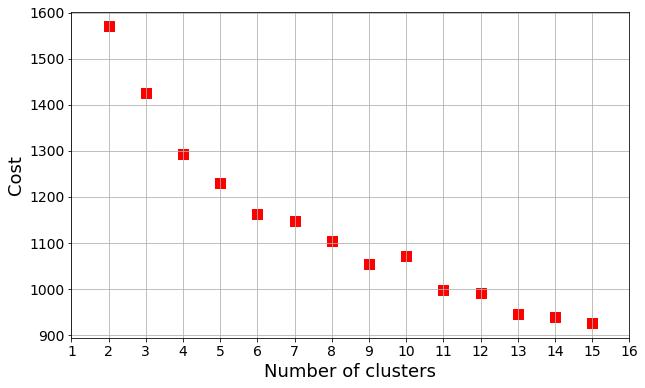

In [27]:
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams.update({'font.size': 14})
plt.scatter(x=K, y=cost,
            marker="s", s=100, color="red")
plt.xlabel("Number of clusters", fontsize=18)
plt.ylabel("Cost", fontsize=18)
plt.xticks(range(1, 17, 1))
plt.grid()
plt.show()

In [36]:
"""create and train clustering algorithm with n clusters"""
n_clusters=5
model = KPrototypes(n_clusters=n_clusters, init="Cao", max_iter=50, random_state=0)
model.fit(df_kproto_final.values, 
          categorical=[df_kproto_final.columns.get_loc(column) for column in ["Category", "Sub Category", "Brand"]])

KPrototypes(gamma=1.432940496946121, max_iter=50, n_clusters=5, random_state=0)

In [37]:
"""save model as clusterer_Belgium.sav"""
#pickle.dump(model, open(PATH_TO_CLUSTERER + 'clusterer_Belgium.sav', 'wb'))

'save model as clusterer_Belgium.sav'

In [39]:
"""store clusters and profiles"""
df_kproto_final["Cluster"] = model.labels_

dict_clusters_sales = dict()
dict_all_sales = {x:{} for x in range(n_clusters)}
for index, row in df_kproto_final.iterrows():
    sales = df_kproto[df_kproto['Category']==row['Category']]\
                     [df_kproto['Sub Category']==row['Sub Category']]\
                     [df_kproto['Brand']==row['Brand']]["Sales in volume"].values
    
    
    dict_all_sales[row["Cluster"]][row["Brand"]+row["Category"]+row["Sub Category"]] = sales
    
    
    if row["Cluster"] not in dict_clusters_sales:
        dict_clusters_sales[row["Cluster"]] = sales
    else:
        dict_clusters_sales[row["Cluster"]] += sales
    
for i in range(0, n_clusters):
    dict_clusters_sales[i] = dict_clusters_sales[i] / df_kproto_final["Cluster"].value_counts().sort_index().values[i]

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_22587/2530360184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kproto_final["Cluster"] = model.labels_
/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_22587/2530360184.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sales = df_kproto[df_kproto['Category']==row['Category']]\


In [48]:
"""save clusters and profiles"""
profiles = pd.DataFrame(dict_clusters_sales)
#profiles.to_csv('profiles_Belgium.csv', index=False)

clusters = df_kproto_final[['Category', 'Sub Category', 'Brand', 'Cluster']]
#clusters.to_csv('profiles_Belgium.csv', index=False)